In [47]:
from keras.layers import LSTM
from keras.models import Sequential, load_model

from timeseries_ml_utils.data import *
from timeseries_ml_utils.statistics import *
from timeseries_ml_utils.encoders import *

import matplotlib.pyplot as plt

# encoders and decoders
linreg = RegressionLine(16)

# fetch data
#data = DataFetcher(["GLD.US"], limit=350)  # 550
data = DataFetcher(["GLD.US"])

print(data.fetch_data().tail())
print(len(data.get_dataframe()))


            GLD.US.Open  GLD.US.High  GLD.US.Low  GLD.US.Close  GLD.US.Volume
Date                                                                         
2018-12-14       116.63       117.30      116.58        117.06        7501660
2018-12-17       117.37       118.03      117.35        117.87        8455007
2018-12-18       117.85       118.20      117.81        118.15        7542875
2018-12-19       118.24       118.96      117.40        117.43       13827509
2018-12-20       119.11       119.74      118.68        119.24       18615143
2257


In [48]:
def regression_encode_decode(y, ref, encode):
    if encode:
        x = np.arange(0, len(y))
        y = normalize(y, ref, True)
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        return np.array([intercept + slope * i for i in range(len(y))])
    else:
        return normalize(y, ref, False)


In [49]:
model_data = DataGenerator(data.get_dataframe(), 
                           {"^trigonometric": identity, 
                            "(Open|High|Low|Close)$": normalize}, 
                           {"GLD.US.Close$": regression_encode_decode},
                           aggregation_window_size=16, batch_size=10, 
                           training_percentage=0.8, 
                           model_path="/tmp/keras-regression-line-price-1")
print(model_data.get_df_columns())
print("feature shape:", model_data.batch_feature_shape)
print("labels shape:", model_data.batch_label_shape)
print("train/test data:", len(model_data), len(model_data.as_test_data_generator()))
print("max batch size:", model_data.get_max_batch_size())
model_data.features, model_data.labels


['GLD.US.Open', 'GLD.US.High', 'GLD.US.Low', 'GLD.US.Close', 'GLD.US.Volume', 'GLD.US.Open_variance', 'GLD.US.High_variance', 'GLD.US.Low_variance', 'GLD.US.Close_variance', 'GLD.US.Volume_variance', 'trigonometric_time.cos_dow', 'trigonometric_time.sin_dow', 'trigonometric_time.cos_woy', 'trigonometric_time.sin_woy', 'trigonometric_time.cos_doy', 'trigonometric_time.sin_doy', 'trigonometric_time.sin_yer', 'trigonometric_time.cos_yer', 'trigonometric_time.sin_dec', 'trigonometric_time.cos_dec']
feature shape: (10, 260, 224)
labels shape: (10, 16)
train/test data: 1566 392
max batch size: 2


([('GLD.US.Open', <function timeseries_ml_utils.encoders.normalize>),
  ('GLD.US.High', <function timeseries_ml_utils.encoders.normalize>),
  ('GLD.US.Low', <function timeseries_ml_utils.encoders.normalize>),
  ('GLD.US.Close', <function timeseries_ml_utils.encoders.normalize>),
  ('trigonometric_time.cos_dow',
   <function timeseries_ml_utils.encoders.identity>),
  ('trigonometric_time.sin_dow',
   <function timeseries_ml_utils.encoders.identity>),
  ('trigonometric_time.cos_woy',
   <function timeseries_ml_utils.encoders.identity>),
  ('trigonometric_time.sin_woy',
   <function timeseries_ml_utils.encoders.identity>),
  ('trigonometric_time.cos_doy',
   <function timeseries_ml_utils.encoders.identity>),
  ('trigonometric_time.sin_doy',
   <function timeseries_ml_utils.encoders.identity>),
  ('trigonometric_time.sin_yer',
   <function timeseries_ml_utils.encoders.identity>),
  ('trigonometric_time.cos_yer',
   <function timeseries_ml_utils.encoders.identity>),
  ('trigonometric_time.s

In [50]:

model = Sequential(name="LSTM-Model-1")
model.add(LSTM(model_data.batch_label_shape[-1],
               name="LSTM-Layer-1",
               batch_input_shape=model_data.batch_feature_shape,
               activation='tanh',
               dropout=0,
               recurrent_dropout=0,
               stateful=True,
               return_sequences=True))

model.add(LSTM(model_data.batch_label_shape[-1] * 2,
               name="LSTM-Layer-2",
               activation='tanh',
               dropout=0,
               recurrent_dropout=0,
               stateful=True,
               return_sequences=True))

model.add(LSTM(model_data.batch_label_shape[-1],
               name="LSTM-Layer-3",
               activation='tanh',
               dropout=0,
               recurrent_dropout=0,
               stateful=True,
               return_sequences=model_data.return_sequences))

model.compile("Adam", loss="mse", metrics=['mae', 'acc'])

train_args = {"epochs": 5,
              "use_multiprocessing": True,
              "workers": 4,
              "shuffle": False,
              "verbose": 1}

fit = model_data.fit(model, train_args, frequency=10, relative_accuracy_function=r_square)
print("done")
#loss: 7.3469e-04 - mean_absolute_error: 0.0204 - acc: 0.1574 - val_loss: 3.5062e-04 - val_mean_absolute_error: 0.0148 - val_acc: 0.0000e+00


Epoch 1/5
1566/1566 [==============================] - 689s 440ms/step - loss: 8.3209e-04 - mean_absolute_error: 0.0215 - acc: 0.1677 - val_loss: 3.5208e-04 - val_mean_absolute_error: 0.0148 - val_acc: 0.2640
Epoch 2/5
Epoch 1/5
1566/1566 [==============================] - 717s 458ms/step - loss: 8.8082e-04 - mean_absolute_error: 0.0222 - acc: 0.1316 - val_loss: 2.6817e-04 - val_mean_absolute_error: 0.0127 - val_acc: 0.2173
Epoch 3/5
1566/1566 [==============================] - 725s 463ms/step - loss: 8.8111e-04 - mean_absolute_error: 0.0222 - acc: 0.2073 - val_loss: 2.7433e-04 - val_mean_absolute_error: 0.0127 - val_acc: 0.2194
Epoch 4/5
1566/1566 [==============================] - 743s 475ms/step - loss: 8.8640e-04 - mean_absolute_error: 0.0223 - acc: 0.0746 - val_loss: 2.6123e-04 - val_mean_absolute_error: 0.0125 - val_acc: 0.0000e+00
Epoch 5/5
1566/1566 [==============================] - 732s 467ms/step - loss: 7.7974e-04 - mean_absolute_error: 0.0206 - acc: 0.1538 - val_loss: 4.65

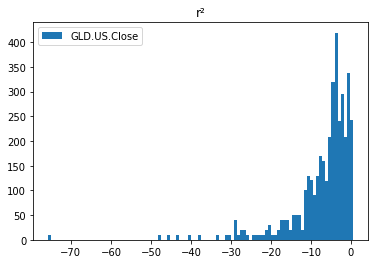

In [51]:
back_test = fit.back_test_history
prediction = fit.predict(-1)
back_test.plot_hist()

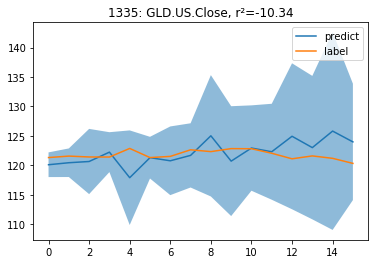

In [64]:
back_test.plot_random_sample()

2018-12-21 00:00:00 2019-01-05 00:00:00
            GLD.US.Close  GLD.US.Close_lower  GLD.US.Close_upper
2019-01-05    121.419853          103.795197          139.044509


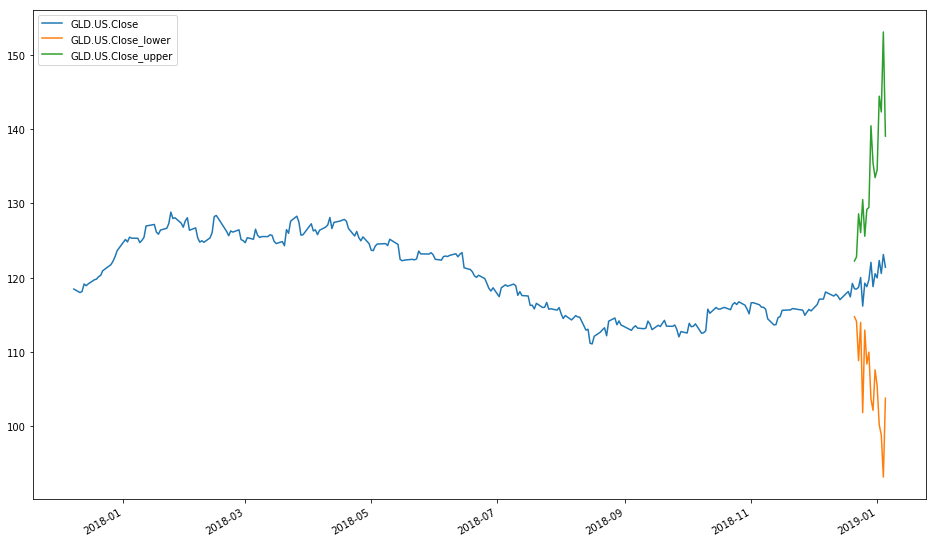

In [65]:
print(prediction.index[-16], prediction.index[-1])
print(prediction[-1:])
prediction.plot(figsize=[16,10])

In [69]:
for layer in model.layers: 
    weights = layer.get_weights()
    print("weights.shape", weights)


weights.shape [array([[-0.00100817,  0.05966556,  0.09367631, ...,  0.03225499,
        -0.21154194, -0.20448616],
       [ 0.02595305, -0.04819136,  0.00902541, ..., -0.10703872,
        -0.20604087, -0.08755435],
       [ 0.07579577,  0.09758949,  0.16686879, ..., -0.05892456,
        -0.12392277, -0.32245892],
       ...,
       [-0.01335935,  0.10163507, -0.26466054, ...,  0.031014  ,
        -0.0464326 , -0.11795986],
       [-0.1202405 ,  0.06219691, -0.08275046, ..., -0.20079479,
        -0.19871555, -0.19994874],
       [ 0.03505126, -0.15788522, -0.34015527, ..., -0.19115412,
        -0.10227881, -0.12438842]], dtype=float32), array([[-1.12691961e-01, -2.17719242e-01,  9.35129672e-02, ...,
        -8.48010033e-02,  4.21268642e-02,  1.41258180e-01],
       [-2.25128475e-04,  1.50333598e-01, -6.42321110e-02, ...,
        -5.13287447e-02, -1.78914785e-01, -1.50007620e-01],
       [ 2.30699033e-01,  1.47083551e-01,  2.04077646e-01, ...,
        -1.09461650e-01, -3.06347907e-02, -2